In [1]:
# file = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"

In [1]:
from fastai.vision.all import *
from fastai.optimizer import ranger

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
path = Path('/home/norbert/Documents/repos/engineerka/data/road')

path_im = path/'unlabeled'
path_lbl = path/'labeled'

In [3]:
lbl_names = get_image_files(path_lbl)
fnames = get_image_files(path_im)

In [4]:
fnames

(#67) [Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_300.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_52.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_405.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_16.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_12.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_294.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_61.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_42.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_22.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled/road_375.png')...]

In [5]:
lbl_names[5]

Path('/home/norbert/Documents/repos/engineerka/data/road/labeled/road_294.png')

In [6]:
fn = 'road_32.png'

In [7]:
im = PILImage.create(f'{path_im}/{fn}')
msk = PILMask.create(f'{path_lbl}/road_32.png')

In [8]:
len(np.unique(msk))

2

In [9]:
np.unique(msk)

array([  0, 255], dtype=uint8)

In [10]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [11]:
p2c = n_codes(lbl_names)

In [12]:
p2c

{0: 0, 1: 255}

In [13]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = path_lbl/f'{fn.stem}{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [14]:
codes = ['lane', 'not lane']

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['not lane']
name2id

{'lane': 0, 'not lane': 1}

In [15]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [16]:
opt = ranger

In [17]:
get_y = lambda o: get_msk(o, p2c)

In [18]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(448),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])


# camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                #    get_items=get_image_files,
                #    splitter=FileSplitter(path/'valid.txt'),
                #    get_y=get_msk,
                #    batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [19]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [20]:
path_im

Path('/home/norbert/Documents/repos/engineerka/data/road/unlabeled')

In [21]:
dls = binary.dataloaders(path_im, bs=4)

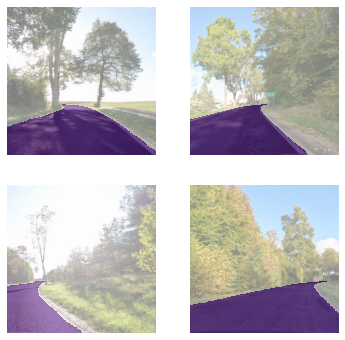

In [22]:
dls.show_batch(cmap='Purples', vmin=0, vmax=1)

In [23]:
# learn = unet_learner(dls, resnet34)
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)


/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# fnames2 = get_files(path/'test', extensions=".png")
# dl = learn.dls.test_dl(fnames2)

SuggestedLRs(valley=6.30957365501672e-05)

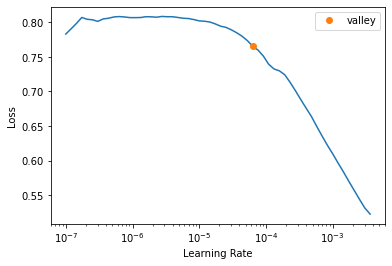

In [24]:
learn.lr_find()

In [24]:
learn.fit(24)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.598300,0.575811,0.951188,00:07
1,0.528337,0.380793,0.998089,00:05
2,0.421943,0.240444,0.993607,00:04
3,0.340405,0.119098,0.982315,00:04
4,0.271283,0.041264,0.985223,00:04
5,0.225316,0.038643,0.980802,00:04
6,0.188315,0.021919,0.998496,00:04
7,0.159973,0.018832,0.995908,00:04
8,0.136421,0.019155,0.997705,00:04
9,0.116935,0.019461,0.997996,00:04


In [24]:
learn.fit(16, 4e-5)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.858356,0.726881,0.364474,00:07
1,0.829381,0.699372,0.500314,00:05
2,0.794298,0.678008,0.615480,00:04
3,0.753405,0.641113,0.768491,00:04
4,0.704765,0.563804,0.877398,00:04
5,0.653417,0.473403,0.947015,00:04
6,0.606882,0.420376,0.974006,00:04
7,0.558456,0.369886,0.990675,00:05
8,0.514988,0.323704,0.998690,00:05
9,0.474718,0.285398,0.999415,00:05


In [24]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.702874,0.631025,0.789444,00:04
1,0.542743,0.466454,0.987248,00:02
2,0.425085,0.268743,0.988388,00:02
3,0.338914,0.144189,0.986828,00:02
4,0.277710,0.097480,0.960791,00:02
5,0.228940,0.049108,0.980883,00:02
6,0.189837,0.042969,0.984124,00:02
7,0.159012,0.033409,0.988427,00:02


In [29]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.717007,0.695786,0.529929,00:02
1,0.566080,0.493093,0.999695,00:02
2,0.443852,0.242476,0.993630,00:02
3,0.345916,0.107153,0.973228,00:02
4,0.271774,0.047028,0.985649,00:02
5,0.219612,0.041545,0.983800,00:02
6,0.180613,0.036269,0.984127,00:02
7,0.152382,0.030376,0.992665,00:02


In [33]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.633995,0.612005,0.844119,00:02
1,0.511466,0.448737,0.995151,00:02
2,0.400336,0.261359,0.990488,00:02
3,0.317073,0.147566,0.964709,00:02
4,0.253104,0.062328,0.972377,00:02
5,0.204890,0.043866,0.980701,00:02
6,0.171322,0.027816,0.992400,00:02
7,0.143845,0.026081,0.990873,00:02


In [24]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.589856,0.420858,0.995665,00:07
1,0.363591,0.186058,0.970978,00:05
2,0.239343,0.055115,0.978498,00:04
3,0.166779,0.037334,0.989589,00:04
4,0.121195,0.032597,0.993121,00:04
5,0.095009,0.043192,0.987909,00:04
6,0.075243,0.036744,0.991026,00:05
7,0.058806,0.033590,0.994181,00:04


In [25]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.009268,0.035742,0.995084,00:05
1,0.009717,0.039207,0.994995,00:05
2,0.010925,0.028174,0.994727,00:05
3,0.019211,0.046042,0.984636,00:05
4,0.033007,0.043676,0.993287,00:05
5,0.027884,0.024636,0.995266,00:05
6,0.023775,0.023888,0.995419,00:04
7,0.020102,0.031491,0.993943,00:04


In [29]:
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.011258,0.033377,0.994140,00:05
1,0.012778,0.039893,0.996614,00:05
2,0.013234,0.023603,0.995279,00:04
3,0.011643,0.025271,0.994839,00:05
4,0.010365,0.024388,0.995071,00:04
5,0.009505,0.021619,0.995220,00:05
6,0.008580,0.021802,0.995399,00:05
7,0.007758,0.023133,0.996127,00:05


In [28]:
lr = 1e-3
lr

0.001

In [25]:
learn.fit(16, lr)

NameError: name 'lr' is not defined

In [29]:
learn.show_results(max_n=2, figsize=(18,8))
# learn.summary()
# learn.lr_find()
# lr = 1e-3
# learn.fit_flat_cos(10, slice(lr))
# learn.save('stage-1')
# learn.load('stage-1');
# learn.show_results(max_n=4, figsize=(12,6))


ValueError: This DataLoader does not contain any batches

In [25]:
# new 68 data images
learn.fit(8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.551057,0.305703,0.997445,00:08
1,0.328997,0.136018,0.916815,00:08
2,0.208667,0.024733,0.991678,00:08
3,0.145782,0.032639,0.984408,00:08
4,0.105878,0.022099,0.992480,00:08
5,0.079721,0.020758,0.993590,00:08
6,0.061464,0.018585,0.996894,00:08
7,0.049164,0.024332,0.992621,00:08


In [24]:
# 68 data epochs = 16
learn.fit(16)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.538209,0.421554,0.999326,00:10
1,0.342847,0.184753,0.991533,00:08
2,0.218800,0.035687,0.989401,00:08
3,0.149635,0.028423,0.992410,00:08
4,0.108097,0.028664,0.991689,00:08
5,0.081940,0.024384,0.992233,00:08
6,0.062843,0.025330,0.991362,00:08
7,0.049977,0.020787,0.993071,00:08
8,0.041265,0.025624,0.992337,00:08
9,0.034031,0.020990,0.994271,00:08


In [26]:
learn.fit(24)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.479697,0.373197,0.999569,00:09
1,0.280319,0.085593,0.964026,00:08
2,0.179845,0.048742,0.984517,00:08
3,0.126758,0.140731,0.994812,00:08
4,0.095563,0.026597,0.993495,00:08
5,0.073748,0.025579,0.991079,00:10
6,0.057929,0.023962,0.993357,00:09
7,0.045938,0.025160,0.991144,00:09
8,0.037132,0.023392,0.994185,00:09
9,0.030445,0.025080,0.991147,00:09


In [30]:
learn.fit(14, 6.31e-05)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.563459,0.548717,0.895785,00:09
1,0.463289,0.364474,0.994078,00:08
2,0.380790,0.251296,0.997402,00:08
3,0.316210,0.187165,0.983132,00:08
4,0.256174,0.108369,0.989573,00:09
5,0.201772,0.063031,0.980851,00:08
6,0.157519,0.044787,0.989883,00:08
7,0.124388,0.036202,0.989776,00:08
8,0.099090,0.032872,0.992123,00:08
9,0.079597,0.032493,0.989681,00:08


In [31]:
learn.fit(8, 6.31e-05)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.016244,0.028479,0.990157,00:09
1,0.015003,0.024583,0.992212,00:08
2,0.014085,0.024673,0.993702,00:08
3,0.013349,0.024464,0.992633,00:08
4,0.013220,0.026163,0.992616,00:09
5,0.012674,0.026469,0.990526,00:08
6,0.012043,0.030836,0.989352,00:08
7,0.012161,0.024552,0.992489,00:08


In [26]:
learn.fit(8, 1e-3)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.572434,0.383333,0.999627,00:11
1,0.351289,0.109650,0.953463,00:08
2,0.219990,0.077540,0.988452,00:08
3,0.149762,0.074817,0.987918,00:09
4,0.111425,0.040519,0.988942,00:09
5,0.084601,0.035609,0.991075,00:09
6,0.066468,0.035455,0.990027,00:09
7,0.052560,0.036908,0.987799,00:09


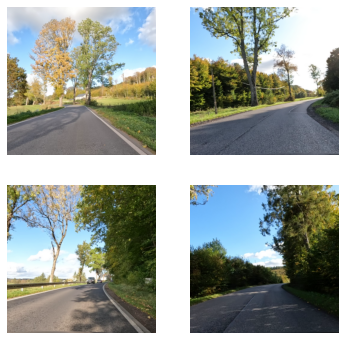

In [27]:
dl = learn.dls.test_dl(fnames[:5])
dl.show_batch()

In [28]:
preds = learn.get_preds(dl=dl)

In [29]:
preds[0].shape

torch.Size([5, 2, 448, 448])

In [30]:
len(codes)

2

In [31]:
pred_1 = preds[0][0]

In [32]:
pred_1.shape

torch.Size([2, 448, 448])

In [33]:
pred_arx = pred_1.argmax(dim=0)

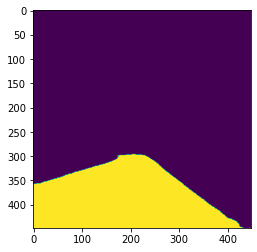

In [34]:
plt.imshow(pred_arx)

In [35]:
pred_arx = pred_arx.numpy()

In [36]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [37]:
im = Image.fromarray(rescaled)

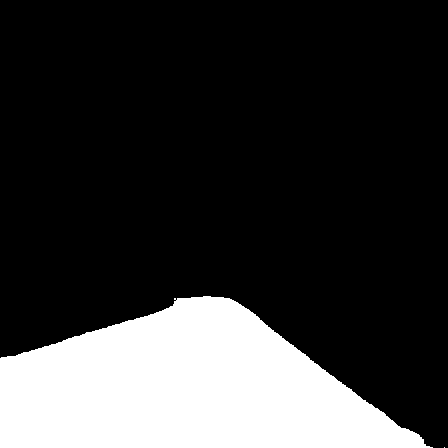

In [38]:
im

In [ ]:
im.save('test.png')